In [ ]:
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from getdist import MCSamples,plots
%matplotlib inline

2024-12-30 11:09:53.413518: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-30 11:09:53.420892: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-30 11:09:53.440591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735537193.471175    7068 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735537193.480296    7068 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-30 11:09:53.508291: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# HMC Run

In [ ]:
# previous approach by Parth : taking samples obtained from MH-MCMC
# mh_run = np.load('MHMCMC_output.npy')
# print(mh_run.shape)

# means = np.mean(mh_run, axis=0)
# print(means)
# sigmas = np.std(mh_run, axis=0)
# print(sigmas)

# means_tf = tf.convert_to_tensor(means, dtype=tf.float32)
# sigmas_tf = tf.convert_to_tensor(sigmas, dtype=tf.float32)

# def unnormalized_target(a0, a1, a2):
#     parameters = tf.stack([a0, a1, a2])  # Stack the parameters into a vector
#     return -tf.reduce_sum(0.5 * ((parameters - means_tf) / sigmas_tf) ** 2)

In [ ]:
data = np.genfromtxt('data_HMC.txt')
x = data[:,0]
x = tf.convert_to_tensor(x, dtype=tf.float32)
y = data[:,1]
y = tf.convert_to_tensor(y, dtype=tf.float32)
sigma = data[:,2]
sigma = tf.convert_to_tensor(sigma, dtype=tf.float32)


def model(x, a0, a1, a2):
    return a0 + a1*x + a2*x**2

def unnormalized_target(a0, a1, a2):
    parameters = tf.stack([a0, a1, a2])  # Stack the parameters into a vector
    return -tf.reduce_sum(0.5 * ((model(x, a0, a1, a2) - y)**2 / sigma))

In [ ]:
print(unnormalized_target(1204, 13.24, 0.97))

tf.Tensor(-13212.38, shape=(), dtype=float32)


In [ ]:
num_results = int(10e4)
num_burnin_steps = int(5e3)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=unnormalized_target,
    num_leapfrog_steps=3,
    step_size=[0.1,0.001,0.0001]
    ),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

@tf.function
def run_chain():
    initial_state = [tf.constant(1300.000),  # Initial guess for a0
                     tf.constant(11.000),    # Initial guess for a1
                     tf.constant(2.00)] # Initial guess for a2
    samples, kernel_results = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=adaptive_hmc,
        trace_fn=lambda _,pkr: pkr.inner_results.is_accepted
    )
    return samples,kernel_results

/home/prasad/anaconda3/envs/pyhmc/lib/python3.10/site-packages/tensorflow_probability/python/__init__.py:70: UserWarning: TensorFloat-32 matmul/conv are enabled for NVIDIA Ampere+ GPUs. The resulting loss of precision may hinder MCMC convergence. To turn off, run `tf.config.experimental.enable_tensor_float_32_execution(False)`. For more detail, see https://github.com/tensorflow/community/pull/287.
  warnings.warn(


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Removed no burn in


<Figure size 600x450 with 0 Axes>

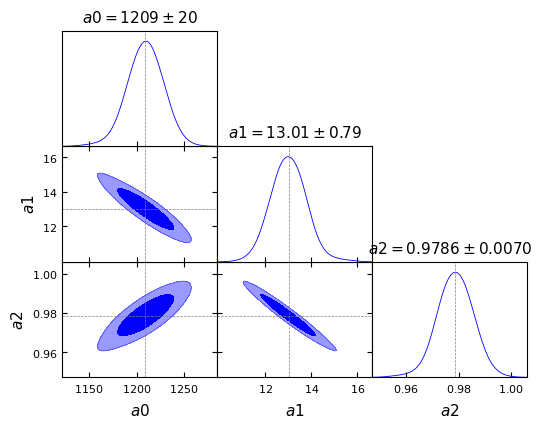

In [ ]:
samples, kernel_results = run_chain()
a0_samples = samples[0]
a1_samples = samples[1]
a2_samples = samples[2]

# Calculate means and standard deviations for a0, a1, and a2
a0_mean = np.mean(a0_samples)
a1_mean = np.mean(a1_samples)
a2_mean = np.mean(a2_samples)
a0_std = np.std(a0_samples)
a1_std = np.std(a1_samples)
a2_std = np.std(a2_samples)

# Create MCSamples instance
samples = MCSamples(samples=np.column_stack([a0_samples, a1_samples, a2_samples]),
                     names=['a0', 'a1', 'a2'],
                     labels=['a0', 'a1', 'a2'])

# Set up the plotting environment with customization
g = plots.get_single_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4
g.settings.title_limit_fontsize = 14

# Define markers with uncertainties
markers = {
    'a0': a0_mean,
    'a1': a1_mean,
    'a2': a2_mean
}
uncertainties = {
    'a0': (a0_mean - a0_std, a0_mean + a0_std),
    'a1': (a1_mean - a1_std, a1_mean + a1_std),
    'a2': (a2_mean - a2_std, a2_mean + a2_std)
}

# Create the triangle plot
g.triangle_plot(
    [samples],
    filled=True,
    markers=markers,
    legend_loc='upper right',
    line_args=[{'ls': '-', 'color': 'blue'}],
    contour_colors=['blue'],
    title_limit=1
)

# MH-MCMC Run

In [ ]:
!pip install emcee

In [ ]:
import emcee

In [ ]:
def log_likelihood_with_prior_dot_product(params, x, y, sigma):
    # Convert params to np.float64 and round to 6 decimal places for consistency with data precision
    a0, a1, a2 = np.round(np.float64(params), 6)

    # Priors given
    if not (500 <= a0 <= 2000 and 0 <= a1 <= 10 and 0 <= a2 <= 5):
        return -np.inf
    else:
        # Compute model minus data
        model_minus_data = (y - (a0 + a1 * x + a2 * x**2)).astype(np.float64).reshape(len(y), 1)

        # Error matrix as a diagonal matrix
        error_square = np.diag(sigma.astype(np.float64))

        # Inverse of the error matrix
        inverse_sigma = np.linalg.inv(error_square)

        # Transpose of model_minus_data
        model_minus_data_transpose = model_minus_data.T

        # Compute the dot product for log-likelihood
        return np.round(-np.dot(model_minus_data_transpose, np.dot(inverse_sigma, model_minus_data)).flatten()[0],6)

In [ ]:
# MCMC setup
ndim = 3                # Number of parameters: a0, a1, a2
nwalkers = 32           # Number of walkers
nsteps = 10000           # Number of steps
p0 = np.random.uniform(low=[500, 0, 0], high=[2000, 10, 5], size=(nwalkers, ndim))  # Initial walker positions


# Initialize sampler
sampler_emcee = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_with_prior_dot_product, args=[X, Y, sigma_squared])
# Run MCMC
sampler_emcee.run_mcmc(p0, nsteps, progress=True)


tau = sampler_emcee.get_autocorr_time()
print(tau)
# Extract samples
samples = sampler_emcee.get_chain(discard=2000,thin=40,flat=True)
print("Shape of samples:", samples.shape)

In [ ]:
a0_samples = np.round(samples[:,0],6)
a1_samples = np.round(samples[:,1],6)
a2_samples = np.round(samples[:,2],6)

In [ ]:
mh_run = np.load('MHMCMC_output.npy') # already run emcee sampler data;
a0_samples = mh_run[:,0]
a1_samples = mh_run[:,1]
a2_samples = mh_run[:,2]

Removed no burn in


<Figure size 600x450 with 0 Axes>

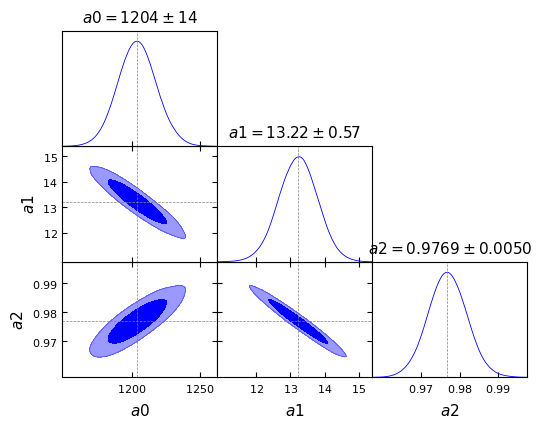

In [ ]:

# Calculate means and standard deviations for a0, a1, and a2
a0_mean = np.mean(a0_samples)
a1_mean = np.mean(a1_samples)
a2_mean = np.mean(a2_samples)
a0_std = np.std(a0_samples)
a1_std = np.std(a1_samples)
a2_std = np.std(a2_samples)

# Create MCSamples instance
samples = MCSamples(samples=np.column_stack([a0_samples, a1_samples, a2_samples]),
                     names=['a0', 'a1', 'a2'],
                     labels=['a0', 'a1', 'a2'])

# Set up the plotting environment with customization
g = plots.get_single_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4
g.settings.title_limit_fontsize = 14

# Define markers with uncertainties
markers = {
    'a0': a0_mean,
    'a1': a1_mean,
    'a2': a2_mean
}
uncertainties = {
    'a0': (a0_mean - a0_std, a0_mean + a0_std),
    'a1': (a1_mean - a1_std, a1_mean + a1_std),
    'a2': (a2_mean - a2_std, a2_mean + a2_std)
}

# Create the triangle plot
g.triangle_plot(
    [samples],
    filled=True,
    markers=markers,
    legend_loc='upper right',
    line_args=[{'ls': '-', 'color': 'blue'}],
    contour_colors=['blue'],
    title_limit=1
)
plt.show()
